In [6]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import pandas as pd
import numpy as np

#NLP Libraries

import nltk
from nltk.corpus import stopwords
#from nltk.tag.stanford import StanfordNERTagger

#Document Reader Libraries

from subprocess import Popen, PIPE
from docx import Document
import pdfminer
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO

from docx import Document
from docx.document import Document as _Document
from docx.oxml.text.paragraph import CT_P
from docx.oxml.table import CT_Tbl
from docx.table import _Cell, Table
from docx.text.paragraph import Paragraph

#Tf-IDf libraries

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#fuzzy logic

import gensim
from fuzzywuzzy import fuzz

## Convert PDF to text function

In [2]:
#Function to convert pdf to text
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)
    fp.close()
    device.close()
    str1 = retstr.getvalue()
    retstr.close()
    return str1


## Read All docx blocks

In [3]:
#Read All Docx
def iter_block_items(parent):
    """
    Generate a reference to each paragraph and table child within *parent*,
    in document order. Each returned value is an instance of either Table or
    Paragraph. *parent* would most commonly be a reference to a main
    Document object, but also works for a _Cell object, which itself can
    contain paragraphs and tables.
    """
    if isinstance(parent, _Document):
        parent_elm = parent.element.body
        # print(parent_elm.xml)
    elif isinstance(parent, _Cell):
        parent_elm = parent._tc
    else:
        raise ValueError("something's not right")

    for child in parent_elm.iterchildren():
        if isinstance(child, CT_P):
            yield Paragraph(child, parent)
        elif isinstance(child, CT_Tbl):
            yield Table(child, parent)

## Convert Document to text 

In [4]:
#Function to convert doc formats (like .doc, .docx, .odt) to text
def document_to_text(filename, file_path):
    if filename[-4:] == ".doc":
        cmd = ['C:/antiword/antiword', file_path] #use antiword command
        p = Popen(cmd, stdout=PIPE)
        stdout, stderr = p.communicate()
        return stdout.decode('ascii', 'ignore')
    elif filename[-5:] == ".docx":
        doc = Document(file_path)
        fullText = []
        para_ix=0
        tbl_ix=0
        for block in iter_block_items(doc):
            block_type=block.__class__.__name__
            if block_type=='Table':
                for row in doc.tables[tbl_ix].rows:
                    for cell in row.cells:
                        for paracell in cell.paragraphs:
                            fullText.append(paracell.text)
                tbl_ix+=1
            elif block_type=='Paragraph':
                fullText.append(doc.paragraphs[para_ix].text)
                para_ix+=1
        return '\n'.join(fullText)
    elif filename[-4:] == ".odt":
        cmd = ['odt2txt', file_path]
        p = Popen(cmd, stdout=PIPE)
        stdout, stderr = p.communicate()
        return stdout.decode('ascii', 'ignore')
    elif filename[-4:] == ".pdf":
        return convert_pdf_to_txt(file_path)

## Data Cleaner

In [5]:

punctuations_list = [',', '?', ':', ';', '!', ')', '(', '\'','"','*','/','<','>','{','}','[',']']

def cleanStr(mystring):
    
    # Removing non-utf charachters with space
    mystring = re.sub(r'[^\x00-\x7F]+', ' ', str(mystring).lower())
    
    for punctuation in punctuations_list:            
        mystring = mystring.replace(punctuation, "".join(punctuation).join("  "))
        
    # Replacing 2 dots with one    
    mystring = mystring.replace("..", ". ")
    
    # Removing Multiple White spaces
    message = ' '.join(mystring.split())

    return message 

In [7]:
os.getcwd()

'C:\\Users\\Shashank Shekar'

In [8]:
os.chdir("D:\\D drive\\DataAnalytics_StudyMaterial\\IIMB-BDA\\ProjectZ\\Iteration2")

In [115]:
#resume_filenames = sorted(glob.glob(os.path.join('./IIM2',"*.*")))
resume_filenames = sorted(glob.glob(os.path.join('./Case Writer-Applications/CaseWriterModel/TrainData',"*.*")))

In [116]:
len(resume_filenames)

100

In [92]:
ITJD_df = pd.read_csv('IT-Jd.csv',sep='\t')

In [93]:
ITJD_df.head()

,Sno,JD
0,1,"Design, build and configure applications\r\nMu..."
1,2,Role : Application Developer Role Description ...
2,3,Role : Application Developer Role Description ...
3,4,Role : Application Developer Role Description ...
4,5,Role : Application Developer Role Description ...


In [101]:
ITJD_df['JD'][0]

'Design, build and configure applications\r\nMust have Skills : Java Enterprise Edition Good to Have Skills : Insurance Fundamentals Job Description Additional Comments : Role: Java Developer Skill: Java Minimum Skill Requirement: (~3-4 pointers against each item) \r\n1) Worked on Life & Annuity Product '

In [124]:
%%time
LenResume=[]
uniqResume=[]
num_words=0

for dfRow in range(len(resume_filenames)):
#for dfRow in range(len(ITJD_df['JD'])):
    #print(resume_filenames[dfRow])
    Cvtxt=cleanStr(document_to_text(resume_filenames[dfRow],resume_filenames[dfRow]))
    LenResume.append(len(Cvtxt.split()))
    #LenResume.append(len(ITJD_df['JD'][dfRow].split()))
    uniqResume.append(len(set(Cvtxt.split())))
    #uniqResume.append(len(set(ITJD_df['JD'][dfRow].split())))
    
    

Wall time: 1min 51s


In [125]:
print(len(LenResume))

100


In [126]:
print(uniqResume[0])

421


In [127]:
ResFileArr=np.asarray(resume_filenames)
LenResumeArr=np.asarray(LenResume)
uniqResumeArr=np.asarray(uniqResume)

In [128]:
CVDes = pd.DataFrame()
CVDes['ResumeFile']=ResFileArr
CVDes['NumWords']=LenResumeArr
CVDes['NumUniqWords']=uniqResume
#ITJD_df['NumWords']=LenResumeArr
#ITJD_df['NumUniqWords']=uniqResumeArr

In [133]:
CVDes[CVDes['NumWords']>=2000].to_csv("name2.csv")


In [33]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline


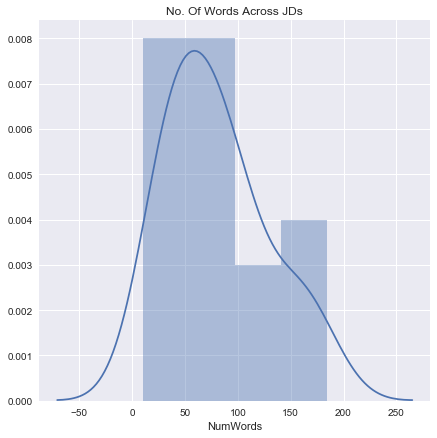

In [113]:
plt.figure(figsize=(7, 7))
plt.title("No. Of Words Across JDs")
#sn.distplot(CVDes.NumWords)
sn.distplot(ITJD_df.NumWords)

In [88]:
print('Average No. Of  Words=',round(CVDes['NumWords'].mean()))
print('SD of Words=',round(CVDes['NumWords'].std()))
print('Min no. of Words=',round(CVDes['NumWords'].min()))
print('Max no.of Words=',round(CVDes['NumWords'].max()))

Average No. Of  Words= 1004
SD of Words= 584
Min no. of Words= 72
Max no.of Words= 4191


In [111]:
print('Average No. Of  Words=',round(ITJD_df['NumWords'].mean()))
print('SD of Words=',round(ITJD_df['NumWords'].std()))
print('Min no. of Words=',round(ITJD_df['NumWords'].min()))
print('Max no.of Words=',round(ITJD_df['NumWords'].max()))

Average No. Of  Words= 80
SD of Words= 48
Min no. of Words= 10
Max no.of Words= 184


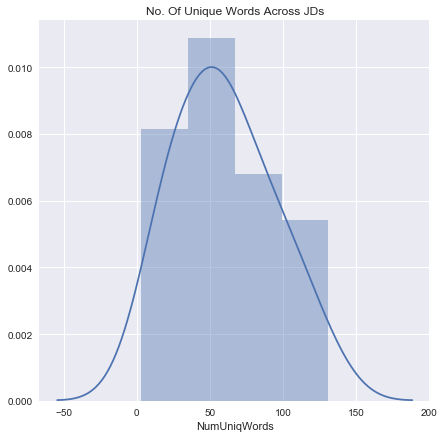

In [114]:
plt.figure(figsize=(7, 7))
plt.title("No. Of Unique Words Across JDs")
#sn.distplot(CVDes.NumUniqWords)
sn.distplot(ITJD_df.NumUniqWords)

In [90]:
print('Average No. Of Unique Words=',round(CVDes['NumUniqWords'].mean()))
print('SD of Unique Words=',round(CVDes['NumUniqWords'].std()))
print('Min no. of Unique Words=',round(CVDes['NumUniqWords'].min()))
print('Max no.of Unique Words=',round(CVDes['NumUniqWords'].max()))

Average No. Of Unique Words= 432
SD of Unique Words= 189
Min no. of Unique Words= 54
Max no.of Unique Words= 1288


In [112]:
print('Average No. Of  Words=',round(ITJD_df['NumUniqWords'].mean()))
print('SD of Words=',round(ITJD_df['NumUniqWords'].std()))
print('Min no. of Words=',round(ITJD_df['NumUniqWords'].min()))
print('Max no.of Words=',round(ITJD_df['NumUniqWords'].max()))

Average No. Of  Words= 60
SD of Words= 34
Min no. of Words= 3
Max no.of Words= 131
